In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **IMPORTING LIBRARIES**

In [2]:
import math
import matplotlib.pyplot as plt
import random
import torch
import scipy.ndimage
import skimage.color
import skimage.io
import skimage.transform
from matplotlib import pyplot as plt
import numpy as np
from math import exp
import torch
from scipy.sparse.linalg import eigsh
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import os
from PIL import Image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
data_dir = '/content/drive/MyDrive/PascalVOC/'

In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((520,520)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### **CLASS FOR CUSTOM DATASET**

In [5]:
#Reference: https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
class SegmentationPascal(Dataset):
  def __init__(self,data_dir,phase,transform=None):
    self.phase=phase
    #for training phase
    if phase=='train':
      self.transform=transform
      self.dir_image= data_dir + 'trainval/Images'
      self.dir_mask = data_dir+ 'trainval'
      self.masks_list= open(data_dir+ 'trainval'+ '/train.txt').readlines()
      self.dir_mask = data_dir + 'trainval/Annotations/'
    
    #for validation phase
    elif phase=='val':
      self.transform=transform
      self.dir_image= data_dir + 'trainval/Images'
      self.dir_mask = data_dir+ 'trainval'
      self.masks_list= open(data_dir+ 'trainval'+ '/val.txt').readlines()
      self.dir_mask = data_dir + 'trainval/Annotations/'

   
    #for testing phase
    else:
      self.transform=transform
      self.dir_image= data_dir + 'test/Images'
      self.dir_mask = data_dir + 'test/Annotations/'
      self.masks_list = os.listdir(self.dir_mask)

  def __len__(self):
    #return number of images in whatever phase we are operating
    return len(self.masks_list)

  def __getitem__(self, ind):
    #This function is used by Pytorch’s Dataset module to get a sample and construct the dataset
    if self.phase == 'test':
      path_for_mask = os.path.join(self.dir_mask+ self.masks_list[ind])
      image_path = os.path.join(self.dir_image, self.masks_list[ind].replace('.png', '.jpg'))
    if self.phase != 'test':
      path_for_mask = os.path.join(self.dir_mask, self.masks_list[ind].replace('\n', '.png'))
      image_path = os.path.join(self.dir_image, self.masks_list[ind].replace('\n', '.jpg'))
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(path_for_mask)
    new_tensor = transforms.PILToTensor()
    mask = new_tensor(mask)
    if self.transform != None:
      image = self.transform(image)
      mask = transforms.Resize((520,520), interpolation=InterpolationMode.NEAREST)(mask)  
    return image, mask

    

In [6]:
image_datasets = {x: SegmentationPascal(data_dir, x, data_transforms) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 2) for x in ['train', 'val']}

dataloaders_test= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 1, shuffle = False, num_workers = 2) for x in ['test']}

dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [7]:
print(dataset_sizes)

{'train': 209, 'val': 213, 'test': 210}


### **DEFINING MODEL**

In [8]:
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights = FCN_ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [9]:
classes = len(weights.meta['categories'])
print(dataloaders_test['test'])

### **RUNNING MODEL ON TEST DATA**

In [10]:
model.eval()
model = model.to(device)
outputs = []
labels = []
with torch.no_grad():
  for inputs, masks in dataloaders_test['test']: #traversing over test data
    inputs = inputs.to(device)
    outputs.append(torch.squeeze(model(inputs)['out'].argmax(1)).cpu().numpy()) #collecting all output images in 'outputs' list
    labels.append(torch.squeeze(masks).numpy()) 

### **TEST ACCURACY**

In [11]:
def get_accuracy(outputs,labels):
  #this function calculates pixel wise accuracy for each test image 
  accuracies=[]
  total_pixels=outputs[0].shape[0]*outputs[0].shape[1]
  for i in range(len(outputs)):
    correct_count=0
    for j in range(outputs[0].shape[0]):
      for k in range(outputs[0].shape[1]):
        if (outputs[i][j][k]==labels[i][j][k]):  #checking if each pixel is matched or not
          correct_count+=1
    accuracy=correct_count/total_pixels #accuracy of each test image
    accuracies.append(accuracy) #collecting all test image accuracies in list
  print("Overall Average Accuracy is:")
  print((np.sum(accuracies)/len(outputs))*100)  #printing average accuracy

In [12]:
get_accuracy(outputs,labels)

Overall Average Accuracy is:
87.93164976049592


###**MEAN IOU FOR TEST DATA**

In [13]:
def get_MeanIOU(outputs,labels,dataset_sizes,classes):
  #this function calculates average MEAN IOU for test set
  IOUs = []
  for j in range(dataset_sizes['test']):
    IOU_sum = 0
    for i in range(classes):  #traversing all 21 classes for each image
      class_arr = np.full(outputs[0].shape, i)
      mask_class = class_arr == labels[j]
      output_class = class_arr == outputs[j]
      intersection = np.logical_and(mask_class, output_class)  #intersection
      class_intersection=np.sum(intersection)
      union = np.logical_or(mask_class, output_class) #union
      class_union=np.sum(union)
      if class_union != 0:
        IOU_sum += class_intersection * 100 / class_union
      else:
        IOU_sum += 100
        
    IOUs.append(IOU_sum / classes)  #IOU for each image = Mean IOU for 21 classes

  print('Overall MeanIOU = ', sum(IOUs)/ len(IOUs))  #Average IOU for all test data

In [14]:
get_MeanIOU(outputs,labels,dataset_sizes,classes)

Overall MeanIOU =  92.10239008690321


### **PALETTE FOR MATCHING CLASS VALUE TO RGB ARRAY**

In [15]:
#palette is used for matching class value to RGB pixel
PALETTE = np.array(
    [
        [0, 0, 0] , # background
        [128, 0, 0], # aeroplane
        [0, 128, 0], # bicycle
        [128, 128, 0], # bird
        [0, 0, 128], # boat
        [128, 0, 128],  # bottle
        [0, 128, 128], # bus 
        [128, 128, 128], # car
        [64, 0, 0], # cat
        [192, 0, 0], # chair
        [64, 128, 0],  # cow
        [192, 128, 0], # dining table
        [64, 0, 128], # dog
        [192, 0, 128], # horse
        [64, 128, 128], # motorbike
        [192, 128, 128], # person
        [0, 64, 0], # potted plant
        [128, 64, 0], # sheep
        [0, 192, 0], # sofa
        [128, 192, 0], # train
        [0, 64, 128], # tv/monitor
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)

In [16]:
def AddPalette(array):
    #This function converts the class value of each pixel into RGB of corresponding class from PALETTE
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

### **VISUALIZING MODEL OUTPUTS ON TEST DATA**


In [24]:
def visualize_model(model, num_of_images,custom_test_image=None):
  #This is written for visualization outputs for test4 and test5 images as well as test data
  model.eval()
  if custom_test_image!=None: #for custom test image(test4 and test5)
    image = torch.unsqueeze(custom_test_image, dim = 0)
    image = image.to(device,dtype=torch.float)
    output_mask = torch.squeeze(model(image)['out'].argmax(1)).cpu().numpy()
    image = torch.squeeze(image)
    output_mask = AddPalette(output_mask)
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                              transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                              ])
    image = invTrans(image)
    fig, axis = plt.subplots(ncols = 2, squeeze = False, figsize = (15,15))
    axis[0,0].imshow(image.cpu().numpy().transpose(1,2,0))
    axis[0,1].imshow(output_mask)
    
    axis[0,0].title.set_text('Original Image')
    axis[0,1].title.set_text('FCN segmented Annotation')
  
    plt.show()
    return

  with torch.no_grad(): #for test data of pascal VOC
    Image_index = random.sample(range(dataset_sizes['test']), num_of_images)
    for i in Image_index:
      image, mask = image_datasets['test'][i]
      image = torch.unsqueeze(image, dim = 0)
      image = image.to(device,dtype=torch.float)
      output_mask = torch.squeeze(model(image)['out'].argmax(1)).cpu().numpy()
      image = torch.squeeze(image)
      mask = torch.squeeze(mask)
      mask = AddPalette(mask.numpy())
      output_mask = AddPalette(output_mask)
      invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
      image = invTrans(image)
      fig, axis = plt.subplots(ncols = 3, squeeze = False, figsize = (15,15))
      axis[0,0].imshow(image.cpu().numpy().transpose(1,2,0))
      axis[0,1].imshow(output_mask)
      axis[0,2].imshow(mask)
      axis[0,0].title.set_text('Original Image')
      axis[0,1].title.set_text('FCN segmented Annotation')
      axis[0,2].title.set_text('Ground truth Annotation')
      plt.show()
    return

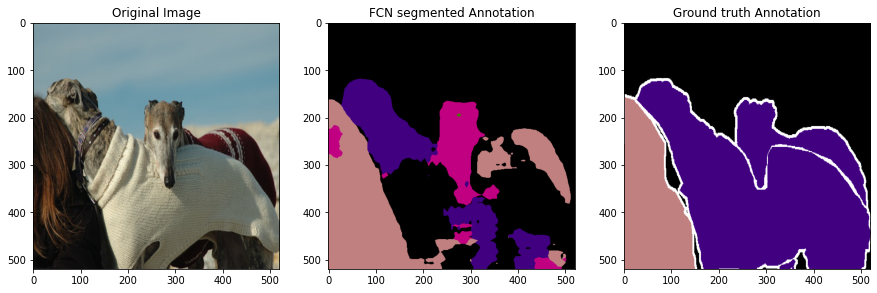

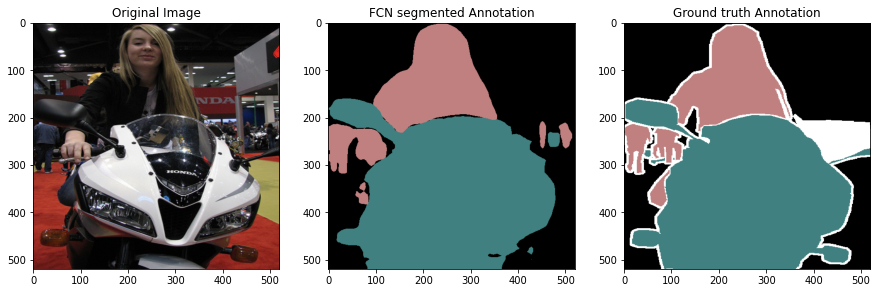

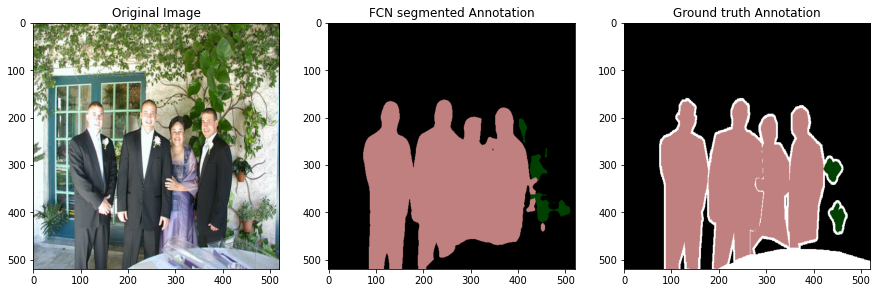

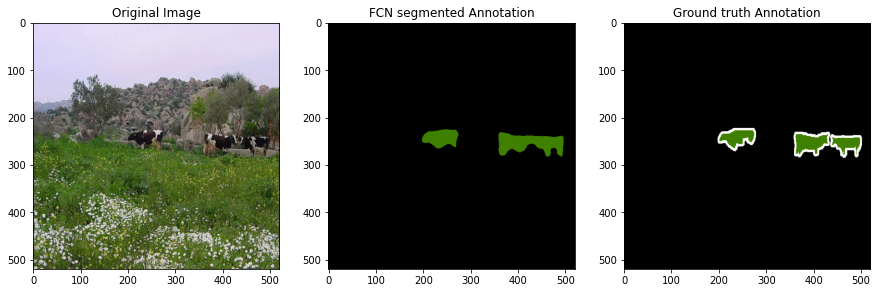

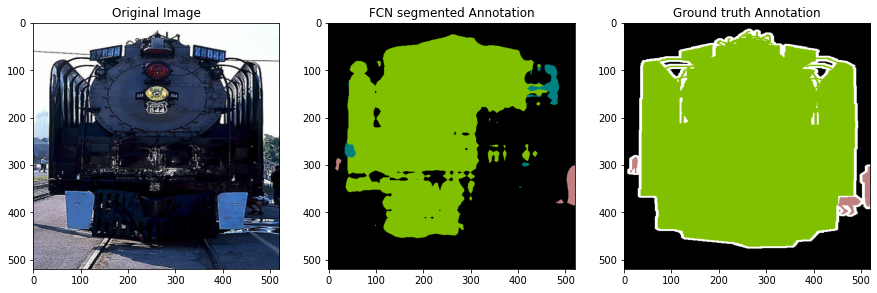

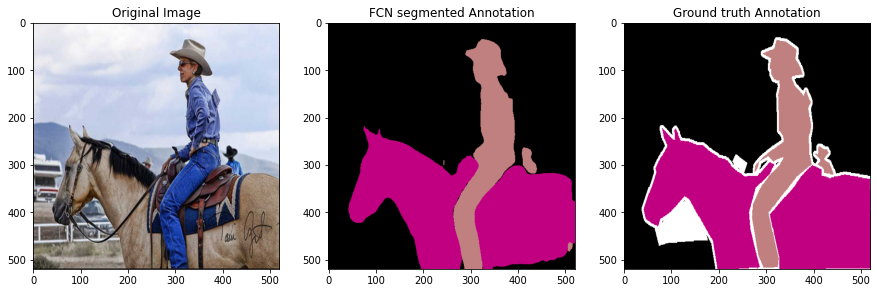

In [18]:
visualize_model(model, 6)

### **FCN on test4 and test5 Images given**

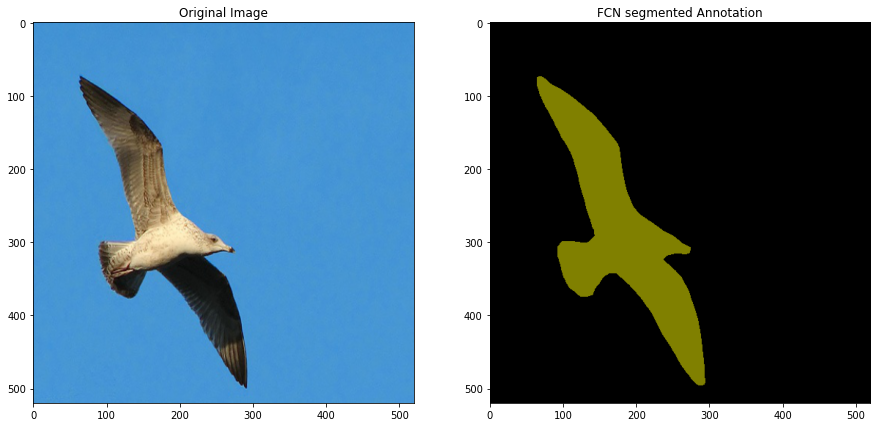

In [19]:
image=skimage.io.imread('test4.jpg')
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)


### **ROTATING TEST IMAGES**

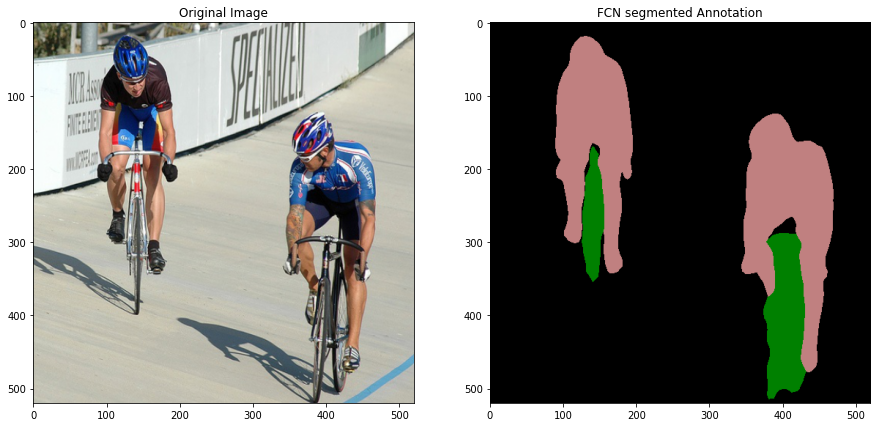

In [20]:
image=skimage.io.imread('test5.jpg')
image=data_transforms(image) #applying transforms on test5.jpg
visualize_model(model, 6,image)

### **ADDING GAUSSIAN NOISE TO TEST IMAGES**

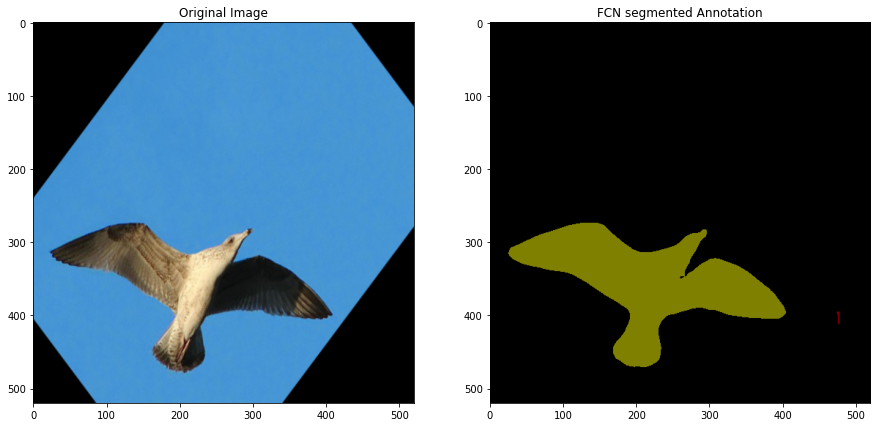

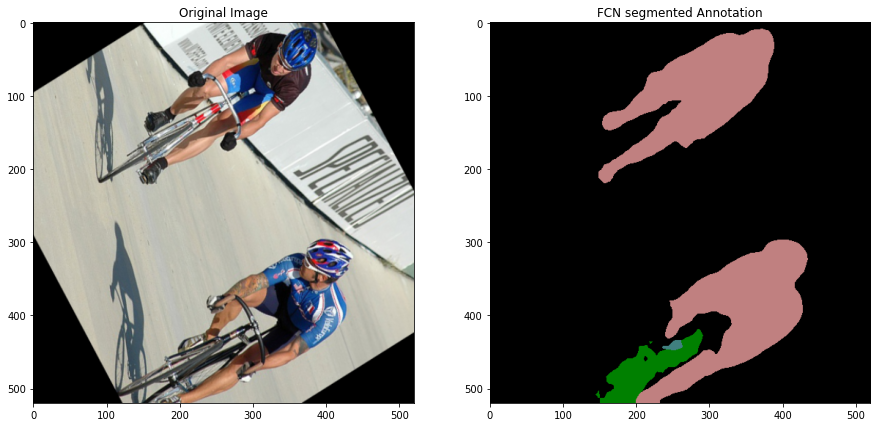

In [25]:
image=skimage.io.imread('test4.jpg')
image = skimage.transform.rotate(image, 45) #rotation
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)
image=skimage.io.imread('test5.jpg')
image = skimage.transform.rotate(image,-60) #rotation
image=data_transforms(image)    #applying transforms on test5.jpg
visualize_model(model, 6,image)

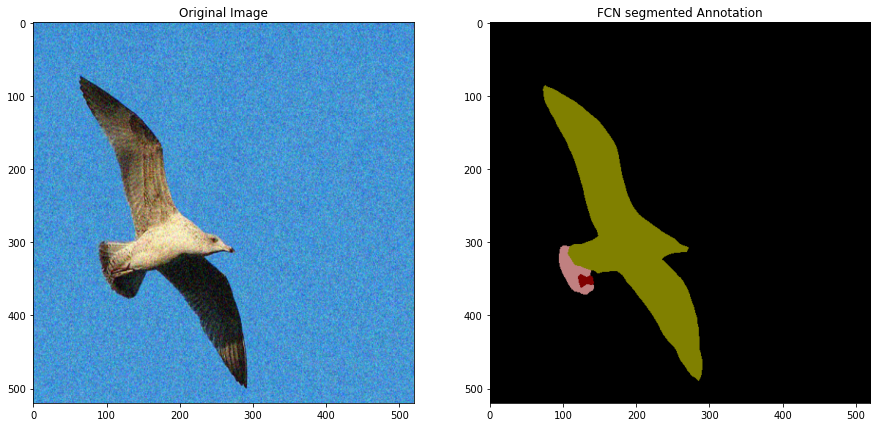

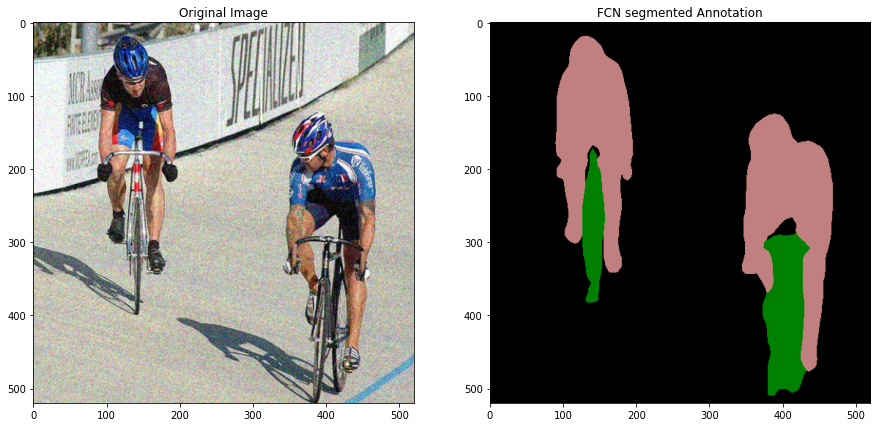

In [26]:
image=skimage.io.imread('test4.jpg')
image = skimage.util.random_noise(image, mode='gaussian') #gaussian noise
image=data_transforms(image)    #applying transforms on test4.jpg
visualize_model(model, 6,image)
image=skimage.io.imread('test5.jpg')
image = skimage.util.random_noise(image, mode='gaussian') #gaussian noise
image=data_transforms(image)    #applying transforms on test5.jpg
visualize_model(model, 6,image)